In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from read_gmsh4 import readGmsh4

In [2]:
# definition d'un objet element

class Node:
    id = 0
    def __init__(self, x, y, region):
        self.id = Node.id
        Node.id += 1
        self.x = x
        self.y = y
        self.region = region
        
    def __repr__(self):
        return f"Node {self.id} [{self.x},{self.y}], region = {self.region}"

class Element:
    id = 0
    def __init__(self, nodes):
        self.nodes = nodes
        self.id = Element.id
        Element.id += 1
        
    def getCoords(self):
        return np.array([[n.x,n.y] for n in self.nodes])
    
    def __repr__(self):
        return f"Element {self.id}\nNodes : {[n.id for n in self.nodes]}\nCoords : {self.getCoords()}"

def plotMesh(elements, nodes, regions = []):
    
    fig, ax = plt.subplots()
    
    regionsSymbols = ["+b", "+r", "+g", "+y"]
    
    for e in elements:
        coords = e.getCoords()
        plt.fill(coords[:,0], coords[:,1], color="greenyellow", alpha=0.5, ec="k")
        
    for (i,r) in enumerate(regions):
        for n in nodes:
            if n.region == r: plt.plot(n.x, n.y, regionsSymbols[i%4])
            
    ax.set_aspect("equal", "box")
    plt.show()

In [41]:
# chargement d'un maillage

Node.id = 0
Element.id = 0

file = "../meshes/t2.msh"
    
regions = [
        (1, 1),
        (1, 2)
        ]
    
elements, nodes = readGmsh4(file, regions) 
dof = len(nodes)

In [4]:
dof

1818

Element 3679
Nodes : [7243, 5541, 5542, 7242]
Coords : [[6.49670762 0.10086606]
 [6.47096774 0.        ]
 [6.58064516 0.        ]
 [6.60546438 0.10097851]]

Node 7243 [6.496707622610066,0.1008660590497796], region = 1

Node 5541 [6.47096774192582,0.0], region = 2



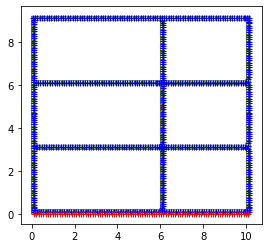

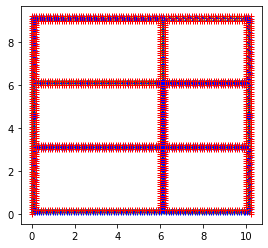

In [42]:
print(elements[0])
print(elements[0].nodes[0])
print(elements[0].nodes[1])
plotMesh(elements, nodes, [1,2]) #region 2 for down boundary
plotMesh(elements, nodes, [1,3]) #region 3 for all other boundaries

In [5]:
# définition des interpolateurs (P1 : linéaire) et de ses dérivées partielles
phi = [
    lambda u,v : 0.25*(1-u)*(1-v), # (-1,-1)
    lambda u,v : 0.25*(1+u)*(1-v), # (+1,-1)
    lambda u,v : 0.25*(1+u)*(1+v), # (+1,+1)
    lambda u,v : 0.25*(1-u)*(1+v), # (-1,+1)
]

duphi = [
        lambda u,v : -0.25*(1-v),   # (-1,-1)
        lambda u,v : 0.25*(1-v),    # (+1,-1)
        lambda u,v : 0.25*(1+v),   # (-1,+1)
        lambda u,v : -0.25*(1+v),   # (+1,+1)
]
dvphi = [
        lambda u,v : -0.25*(1-u),   # (-1,-1)
        lambda u,v : -0.25*(1+u),   # (+1,-1)
        lambda u,v : 0.25*(1+u),    # (-1,+1)
        lambda u,v : 0.25*(1-u),    # (+1,+1)
]

gradPhi = [
        lambda u,v: np.array([duphi[i](u,v), dvphi[i](u,v)])
        for i in range(4)
]

# fonction retournant l'interpolateur selon les 4 fonctions phi pour les 4 valeurs aux noeuds X
def interp(phiList, X):
    return lambda u,v : sum([phi(u,v)*x for phi,x in zip(phiList, X)])

In [6]:
# Pour chaque élément calcul:
# - du jacobien
# - de l'inverse de la matrice jacobienne

for e in elements:

    coords = e.getCoords()
    X, Y = coords[:,0], coords[:,1]

    dxdu = interp(duphi, X)
    dxdv = interp(dvphi, X)        
    dydu = interp(duphi, Y)
    dydv = interp(dvphi, Y)
    
    e.detJ = lambda u,v : dxdu(u,v)*dydv(u,v) - dxdv(u,v)*dydu(u,v)

    e.iJ = lambda u,v :  np.array(
        [[dydv(u,v), -dydu(u,v)],
        [-dxdv(u,v), dxdu(u,v)]]
    )/e.detJ(u,v)

In [7]:
# Détermination d'une règle de quadrature 

# nombre de points de quadrature (par dimension)
Nquad = 5 

# importation poids et abscices Gauss-Legendre
data = np.loadtxt(f"../quadratureRules/gl_{Nquad:02d}.tab")
w_i, xi_i = data[:,0], data[:,1] 

# Compute the 2D integral of f(u,v) over [-1,1]x[-1,1]

int2D = lambda f: sum([ sum([w1*w2 * f(xi1, xi2) for xi1,w1 in zip(xi_i, w_i)]) for xi2,w2 in zip(xi_i, w_i)])

In [8]:
# Calcul des matrices élémentaires locales -> à optimiser

for e in tqdm(elements):

    e.Ke = np.zeros((4,4))
    e.Me = np.zeros((4,4))
    
    for i in range(4):
        for j in range(4):

            fk = lambda u,v: (e.iJ(u,v)@gradPhi[i](u,v))@(e.iJ(u,v)@gradPhi[j](u,v))*e.detJ(u,v)
            e.Ke[i,j] = int2D(fk)

            fm = lambda u,v: phi[i](u,v)*phi[j](u,v)*e.detJ(u,v)
            e.Me[i,j] = int2D(fm)

100%|██████████████████████████████████████████████████████████████████████████████| 1226/1226 [00:42<00:00, 28.76it/s]


In [9]:
# Calcule des matrices globales -> à optimiser
K = np.zeros((dof,dof))
M = np.zeros((dof,dof))
F = np.zeros(dof)

for e in elements:
    for (i,n1) in enumerate(e.nodes):
        for (j,n2) in enumerate(e.nodes):
            K[n1.id-1,n2.id-1] += e.Ke[i,j]
            M[n1.id-1,n2.id-1] += e.Me[i,j]

In [28]:
# résolution temporelle

Nit = 4000
cfl = 0.01
#Δx = L/N
Δx = 0.2
Δt = Δx* cfl
T = Δt*Nit 

time = np.linspace(0,T,Nit)

U = np.zeros((Nit, dof))
dU = np.zeros((Nit, dof))
ddU = np.zeros((Nit, dof))

In [26]:
# Conditions aux limites

boundary = 2
boundary_list = []

for n in nodes:
    if n.region == boundary:
        boundary_list.append(n.id-1)
        K[n.id-1,:] = 0
        K[n.id-1, n.id-1] = 1

boundary_id = np.array(boundary_list)

In [25]:
# définition source

f = lambda t : np.sin(t)

In [18]:
# inverting mass matrix

iM = np.linalg.inv(M)

In [19]:
# tests sur valeurs paramètres
print(f"CFL = {Δt/Δx}")
print(f"Δx = {Δx}m while λmin ~ {1/(4*f0)}")

CFL = 0.01
Δx = 0.1m while λmin ~ 0.4


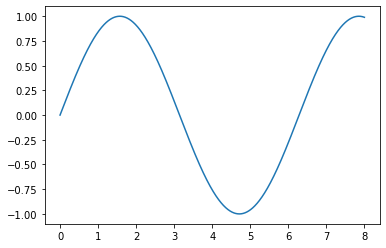

In [15]:
plt.plot(time, f(time))

In [29]:
for i in tqdm(range(1,Nit)):
    F[boundary_id] = f(i*Δt)
    U[i,:] = U[i-1,:] + Δt*dU[i-1,:] + (Δt**2 /2)*ddU[i-1,:]
    ddU[i,:] = iM @ (F - K@U[i,:])
    dU[i,:] = dU[i-1,:] + (Δt/2)*(ddU[i-1,:] + ddU[i,:])

100%|█████████████████████████████████████████████████████████████████████████████| 3999/3999 [00:05<00:00, 668.59it/s]


(-1.0, 1.0)

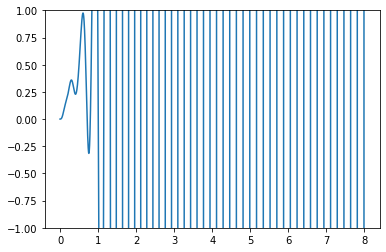

In [34]:
plt.plot(time, U[:,boundary_id[1]])
plt.ylim([-1, 1])

In [24]:
idx = 20
plt.imshow(U[idx,:].reshape((N+1,N+1)))
plt.colorbar()

NameError: name 'N' is not defined

In [25]:
import matplotlib.animation as animation

NameError: name 'N' is not defined

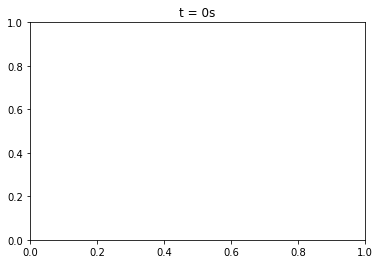

In [26]:
# animation

U = U[:50,:]

fig, ax = plt.subplots()
title = ax.set_title("t = 0s")

umax = max(U.max(), -U.min())
i = 0
im = ax.imshow(U[i,:].reshape((N+1,N+1)), vmin=-umax, vmax=umax)

def updatefig(i): 
    im.set_data(U[i,:].reshape((N+1,N+1)))
    title.set_text(f"t = {i*Δt:.3f}s")
    
anim = animation.FuncAnimation(fig, updatefig, interval=30, frames=Nit)
anim.event_source.start()
plt.show()

In [157]:
# updating figure

fig = plt.figure()
plt.title("it = s")


i = 0
plt.imshow(U[i,:].reshape((N+1,N+1)))
plt.colorbar()
i_update = 30

def onclick(event):
    global i
    i = (i + i_update)%Nit
    umax = max(U[i,:].max(), -U[i,:].min())
    fig.clear()
    
    plt.imshow(U[i,:].reshape((N+1,N+1)), vmin=-umax, vmax=umax)
    plt.title(f"it = {i}")
    plt.colorbar()
    plt.draw()
    
fig.canvas.mpl_connect("key_press_event",onclick)
plt.draw()
plt.show()
